# Adding a background to the simple peakbag

I'm going to add a proper treatment of the mode frequencies. The remaining caveats are:

- I will not impose a complex prior on linewidth
- I will not impose a complex prior on mode heights
- I am not accounting for any asphericities due to near-surface magnetic fields

The expected effect of this will be, in order:

- Increased uncertainty on linewidths
- Increased runtime as the mode heights are less constrained
- Possible linewidth broadening or shifting of mode frequencies if there are significant frequency shifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz

In [2]:
target = 3632418
mal = pd.read_csv('../../data/malatium.csv', index_col=0)
idx = np.where(mal.KIC == target)[0][0]
star = mal.loc[idx]
kic = star.KIC
numax = star.numax
dnu = star.dnu

In [3]:
sfile = glob.glob('../../data/*{}*.pow'.format(kic))
data = ascii.read(sfile[0]).to_pandas()
ff, pp = data['col1'].values, data['col2'].values

In [4]:
# Read in the mode locs
cop = pd.read_csv('../../data/copper.csv',index_col=0)
cop = cop[cop.l != 3]
modelocs = cop[cop.KIC == str(kic)].Freq.values[12:21]
elocs = cop[cop.KIC == str(kic)].e_Freq.values[12:21]
modeids = cop[cop.KIC == str(kic)].l.values[12:21]

lo = modelocs.min() - .25*dnu
hi = modelocs.max() + .25*dnu

sel = (ff > lo) & (ff < hi)
f = ff[sel]
p = pp[sel]

In [5]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

In [7]:
try:
    backdir = glob.glob('/home/oliver/PhD/mnt/RDS/malatium/backfit/'
                        +str(kic)+'/*_fit.pkl')[0]
    with open(backdir, 'rb') as file:
        backfit = pickle.load(file)

    labels=['loga','logb','logc','logd','logj','logk','white','scale','nyq']
    res = np.array([np.median(backfit[label]) for label in labels])
    res[0:6] = 10**res[0:6]
    
    phi_ = np.array([np.median(backfit[label]) for label in labels])
    phi_sigma = pd.DataFrame(backfit)[labels].cov()
    phi_cholesky = np.linalg.cholesky(phi_sigma)
    
    model = get_background(ff, *res)
    m = get_background(f, *res)
except IndexError:
    pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, pf*(cds.ppm**2/u.microhertz))
    p = pg.flatten().power.value * 2

(0, 50)

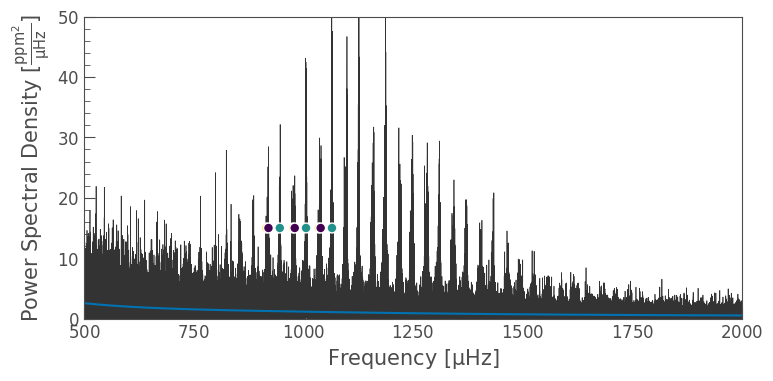

In [8]:
pg = lk.Periodogram(ff*u.microhertz, pp*(cds.ppm**2 / u.microhertz))
ax = pg.plot()
ax.plot(ff, model)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='w',zorder=100)
ax.set_xlim(500,2000)
ax.set_ylim(0, 50)

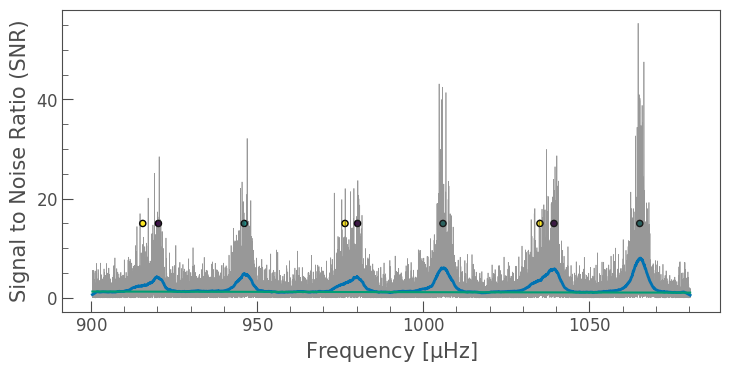

In [11]:
pg = lk.periodogram.SNRPeriodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=3.).plot(ax=ax, linewidth=2)
ax.plot(f, m)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

In [20]:
l = cop[cop.KIC == str(kic)].l
print('Modes of l = 0: {}'.format(len(l[l==0])))
print('Modes of l = 1: {}'.format(len(l[l==1])))
print('Modes of l = 2: {}'.format(len(l[l==2])))

Modes of l = 0: 18
Modes of l = 1: 18
Modes of l = 2: 18


## Finding the mode frequencies through the asymptotic relation

We have good constraints on the mode frequencies from previous studies, but since we are using the same data, we don't want to use their posteriors as priors on our frequencies. Instead we want to find a way to include the prior knowledge from previous studies without making our study dependent on them.

The locations of the radial $l = 0$ modes can be predicted from the asymptotic relation. Radial modes of consecutive overtones are separated by the large frequency separation $\Delta\nu$, in principle. However in practice, these mode frequencies can be subject to some curvature, as well as noise from glitches in the sound speed profile in the stellar interior.

We're going to omit a detailed treatment of glitches for now, but we *will* include a curvature term, using the astymptotic relation presented in [Vrard et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..84V/abstract), which goes as

$\large\nu_{l=0} = (\bar{n} + \epsilon + (\frac{\alpha}{2}(n_{\rm max} - \bar{n})^2)) \Delta\nu + \Delta$

where $\nu_{\rm l=0}$ is the frequency locations of all l=0 modes at overtones $\bar{n}$, $\epsilon$ is the phase offset, $\alpha$ determines the curvature, $\Delta\nu$ is the large separation, and $n_{\rm max}$ is the overtone closest to $\nu_{\rm max}$, round which the curvature is centered, and is given by

$n_{\rm max} = \frac{\nu_{\rm max}}{\Delta\nu} - \epsilon$,

and $\Delta$ is the noise on the frequency positions. Including this noise term allows us to formalize the 'smoothness condition' ([Davies et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.2183D/abstract)), where we specify that the difference in large frequency separation between subsequent radial modes should be close to zero, with some scatter. We therefore specify $\Delta$ as:

$\Delta = \mathcal{N}(0, \sigma_\Delta)$,

where $\sigma_\Delta$ is a free parameter.

The positions of the dipole and octopole $l = 1, 2$ modes are then determined from the radial frequencies, as

$\nu_{l=1} = \nu_{l=0} + \mathcal{N}(\delta\nu_{01}, \sigma_{01})$

$\nu_{l=2} = \nu_{l=0} + \mathcal{N}(\delta\nu_{02}, \sigma_{02})$

where $\delta\nu_{01}$ and $\delta\nu_{02}$ are the small separations between the radial frequency and the dipole and octopole frequencies of the same radial degree. $\sigma_{01}$ and $\sigma_{02}$ are the uncertainties on these separations. All are free parameters.

So we know have a complex hierarchical system where the mode frequencies are latent parameters, and we have a bunch of hyperparameters controlling them, giving them noise and curvature. These hyperparameters are where we include our *prior* information from the Kages and LEGACY papers, as first guesses and as means on the distributions from which they are drawn.

$\epsilon \sim \mathcal{N}(\epsilon_{\rm prior}, ...)$

$\alpha \sim \mathcal{N}(\alpha_{\rm prior}, ...)$

$\Delta\nu \sim \mathcal{N}(\Delta\nu_{\rm prior}, ...)$

$\nu_{\rm max} \sim \mathcal{N}(\nu_{\rm max, \rm prior}, ...)$

$\delta\nu_{01} \sim \mathcal{N}(\delta\nu_{01, \rm prior}, ...)$

$\delta\nu_{02} \sim \mathcal{N}(\delta\nu_{02, \rm prior}, ...)$

where I haven't quite decided what the variances will be yet. $\epsilon$ and $\alpha$ will be determined from a fit to the mode frequencies of each star. The rest will be calculated directly as average values from the prior mode frequencies.

The noise terms $\sigma_\Delta$, $\sigma_{01}$ and $\sigma_{02}$ will all be drawn from lognormal distributions, to ensure they don't go too close to zero.

Notice that there's something a little off with this: It requires exactly one of each $l$ mode at each overtone number $n$. For the star we're testing on, this isn't a problem--- we have 18 of each. However we should try and build a structure robust against edge cases with uneven numbers of modes.

# Build the model

In [12]:
class model():
    def __init__(self, f, f0_, f1_, f2_):
        self.f = f
        self.npts = len(f)
        self.M = [len(f0_), len(f1_), len(f2_)]


    def harvey(self, a, b, c):
        harvey = 0.9*a**2/b/(1.0 + (self.f/b)**c);
        return harvey

    def get_apodization(self, nyquist):
        x = (np.pi * self.f) / (2 * nyquist)
        return (np.sin(x)/x)**2

    def get_background(self, loga, logb, logc, logd, logj, logk, white, scale, nyq):
        background = np.zeros(len(self.f))
        background += self.get_apodization(nyq) * scale  \
                        * (self.harvey(10**loga, 10**logb, 4.) \
                        +  self.harvey(10**logc, 10**logd, 4.) \
                        +  self.harvey(10**logj, 10**logk, 2.))\
                        +  white
        return background        
        
    def epsilon(self, i, l, m):
    #We use the prescriptions from Gizon & Solanki 2003 and Handberg & Campante 2012
        if l == 0:
            return 1
        if l == 1:
            if m == 0:
                return np.cos(i)**2
            if np.abs(m) == 1:
                return 0.5 * np.sin(i)**2
        if l == 2:
            if m == 0:
                return 0.25 * (3 * np.cos(i)**2 - 1)**2
            if np.abs(m) ==1:
                return (3/8)*np.sin(2*i)**2
            if np.abs(m) == 2:
                return (3/8) * np.sin(i)**4
        if l == 3:
            if m == 0:
                return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
            if np.abs(m) == 1:
                return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
            if np.abs(m) == 2:
                return (15/8) * np.cos(i)**2 * np.sin(i)**4
            if np.abs(m) == 3:
                return (5/16)*np.sin(i)**6
        
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
    
    def mode(self, l, freqs, hs, ws, i, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * self.epsilon(i, l, m), 
                                     ws[idx])
  
    def model(self, p):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi = p
        
        # Unpack background parameters
        loga = phi[0]
        logb = phi[1]
        logc = phi[2]
        logd = phi[3]
        logj = phi[4]
        logk = phi[5]
        white = phi[6]
        scale = phi[7]
        nyq = phi[8]
        
        # Calculate the modes
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, i)
        self.mode(1, f1, h1, g1, i, split)
        self.mode(2, f2, h2, g2, i, split)
        self.modes *= self.get_apodization(nyq)
        
        #Calculate the background
        self.back = self.get_background(loga, logb, logc, logd, logj, logk,
                                       white, scale, nyq)
        
        #Create the model
        self.mod = self.modes + self.back
        return self.mod

    def __call__(self, p):
        return self.model(p)

In [13]:
f0_ = modelocs[modeids==0]
f1_ = modelocs[modeids==1]
f2_ = modelocs[modeids==2]
f0_e = elocs[modeids==0]
f1_e = elocs[modeids==1]
f2_e = elocs[modeids==2]

Do some first guesses for height

In [14]:
def gaussian(locs, l, numax, Hmax0):
    fwhm = 0.25 * numax
    std = fwhm/2.355
    
    Vl = [1.0, 1.22, 0.71, 0.14]
    
    return Hmax0 * Vl[l] * np.exp(-0.5 * (locs - numax)**2 / std**2)   

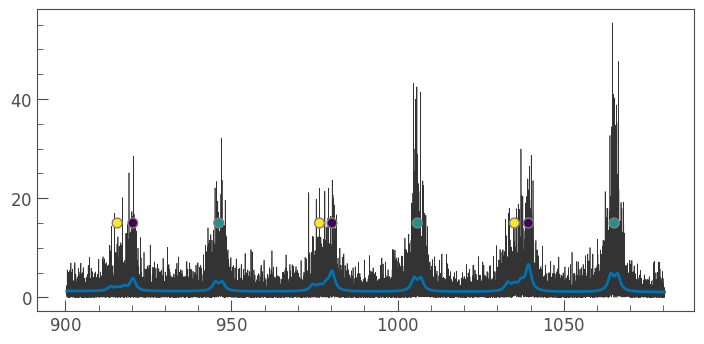

In [15]:
numax = star.numax
init =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       np.ones(len(f0_)) * 2.0,     # l0 widths
       np.ones(len(f1_)) * 2.0,     # l1 widths
       np.ones(len(f2_)) * 2.0,     # l2 widths
       np.sqrt(gaussian(f0_, 0, numax, 15.) * 2.0 * np.pi / 2.0) ,# l0 heights
       np.sqrt(gaussian(f1_, 1, numax, 15.) * 2.0 * np.pi / 2.0) ,# l1 heights
       np.sqrt(gaussian(f2_, 2, numax, 15.) * 2.0 * np.pi / 2.0) ,# l2 heights
       1.0 * np.sin(np.pi/2),       # projected splitting
       np.pi/2.,                    # inclination angle
       np.copy(phi_)]               # background parameters (in log)

mod = model(f, f0_, f1_, f2_)
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    ax.plot(f, mod(init), lw=2)
    ax.scatter(modelocs, [15]*len(modelocs),c=modeids, s=50, edgecolor='grey', zorder=100)


# Build the priors in PyMC3

In [39]:
pm_model = pm.Model()

with pm_model:   
    # Frequencies
    f0 = pm.Normal('f0', mu=f0_, sigma=f0_e, testval=f0_, shape=len(f0_))
    f1 = pm.Normal('f1', mu=f1_, sigma=f1_e, testval=f1_, shape=len(f1_))
    f2 = pm.Normal('f2', mu=f2_, sigma=f2_e, testval=f2_, shape=len(f2_))
    
    # Mode linewidths
    g0 = pm.HalfNormal('g0', sigma=2.0, testval=init[3], shape=len(init[3]))
    g1 = pm.HalfNormal('g1', sigma=2.0, testval=init[4], shape=len(init[4]))
    g2 = pm.HalfNormal('g2', sigma=2.0, testval=init[5], shape=len(init[5]))
    
    # Mode amplitudes
    a0 = pm.HalfNormal('a0', sigma=20., testval=init[6], shape=len(init[6]))
    a1 = pm.HalfNormal('a1', sigma=20., testval=init[7], shape=len(init[7]))
    a2 = pm.HalfNormal('a2', sigma=20., testval=init[8], shape=len(init[8]))
    
    # Mode heights (determined by amplitude and linewidth)
    h0 = pm.Deterministic('h0', 2*a0**2/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*a1**2/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*a2**2/np.pi/g2)
    
    # Rotation and inclination parameterizations
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init[10])
    cosi = pm.Uniform('cosi', 0., 1.)
    
    # Detangled inclination and splitting
    i = pm.Deterministic('i', np.arccos(cosi))
    split = pm.Deterministic('split', xsplit/pm.math.sin(i))
    
    # Background treatment
    phi = pm.MvNormal('phi', mu=phi_, chol=phi_cholesky, testval=phi_, shape=len(phi_))
    
    # Smoothness condition
    p0 = pm.Deterministic('p0', -0.125 * np.sum(
                            np.diff(np.diff([f0[i] for i in range(len(f0_))]))**2))
    p1 = pm.Deterministic('p1', -0.125 * np.sum(
                            np.diff(np.diff([f1[i] for i in range(len(f1_))]))**2))
    p2 = pm.Deterministic('p2', -0.125 * np.sum(
                            np.diff(np.diff([f2[i] for i in range(len(f2_))]))**2))
    p02 = pm.Deterministic('p02', -0.25 * np.sum(
                            np.diff([f0[i]-f2[i] for i in range(len(f2_))])**2))

    
    #Model
    fit = mod([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, phi])
    
    like = pm.Gamma('like', alpha=1, beta=1.0/fit, observed=p)

In [20]:
with pm_model:
    trace = pm.sample(chains=4)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [phi, cosi, xsplit, a2, a1, a0, g2, g1, g0, f2, f1, f0]
Sampling 4 chains: 100%|██████████| 4000/4000 [02:54<00:00, 22.86draws/s]


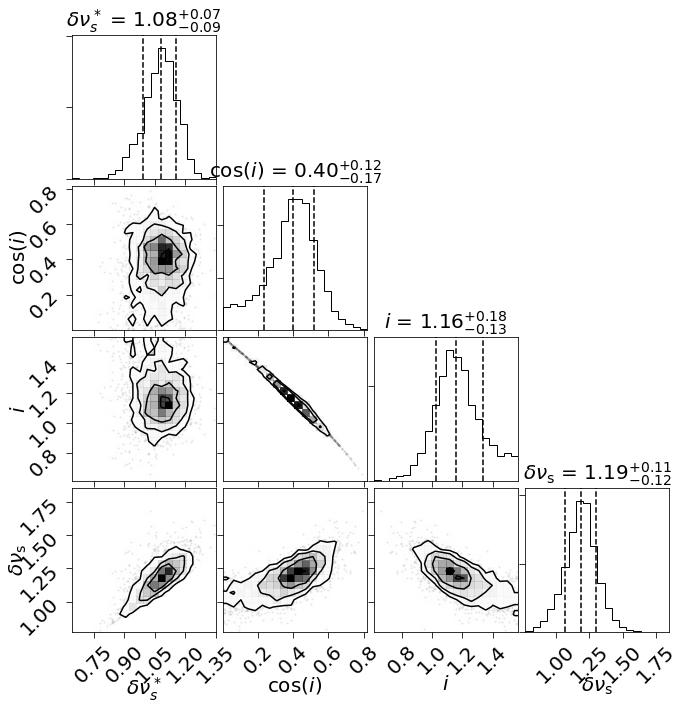

In [21]:
labels=['xsplit','cosi','i','split']
chain = np.array([trace[label] for label in labels])
verbose = [r'$\delta\nu_s^*$',r'$\cos(i)$',r'$i$',r'$\delta\nu_{\rm s}$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84]
              ,show_titles=True)
plt.show()

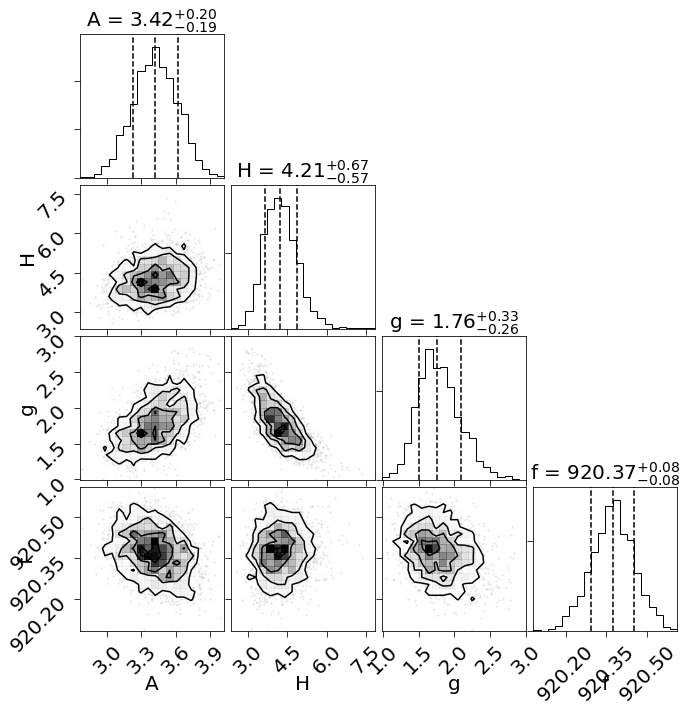

In [22]:
for idx in range(len(trace['h0'].T)):
    chain = np.array([trace['a0'].T[idx], trace['h0'].T[idx], trace['g0'].T[idx], trace['f0'].T[idx]])
    corner.corner(chain.T, labels=['A','H','g','f'],
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    plt.show()

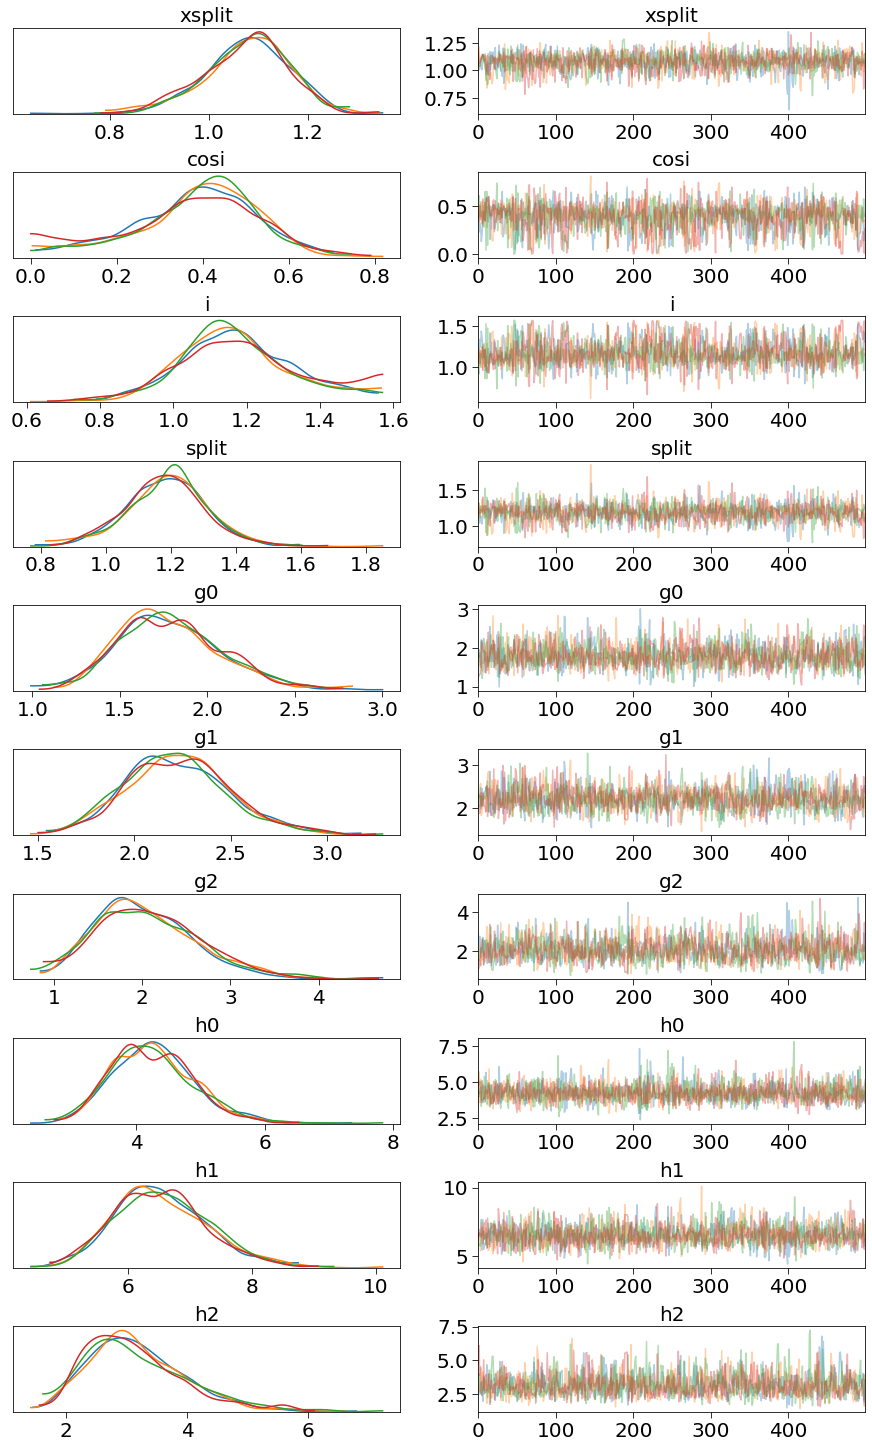

In [23]:
pm.traceplot(trace, var_names=['b','xsplit','cosi','i','split','g0','g1','g2','h0','h1','h2'])
plt.show()

In [24]:
cmap = sns.color_palette('plasma', n_colors = 10)

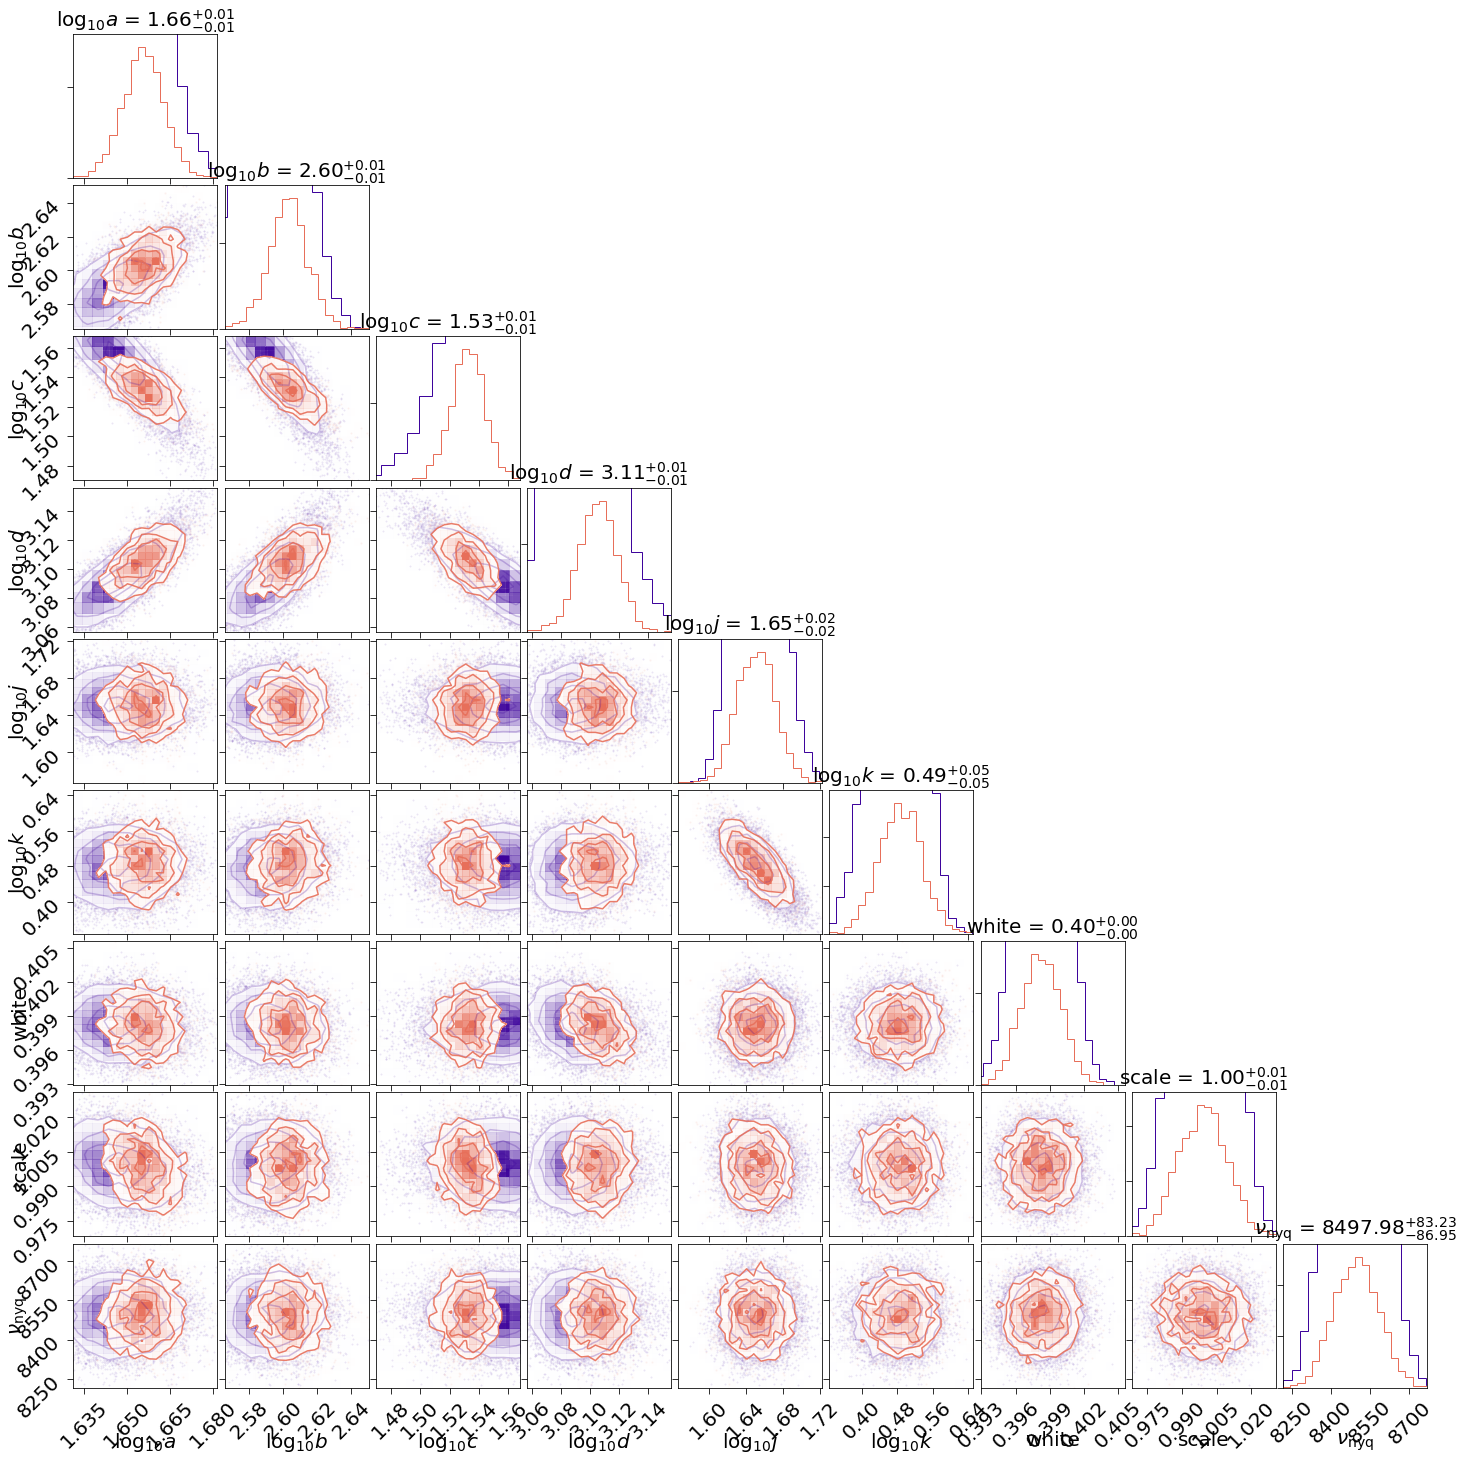

In [25]:
labels=['loga','logb','logc','logd','logj','logk',
        'white','scale','nyq']
verbose=[r'$\log_{10}a$',r'$\log_{10}b$',
        r'$\log_{10}c$',r'$\log_{10}d$',
        r'$\log_{10}j$',r'$\log_{10}k$',
        'white','scale',r'$\nu_{\rm nyq}$']

backchain = np.array([backfit[label] for label in labels]).T
phichain = np.array([trace['phi'][:,idx] for idx in range(len(phi_))]).T
limit = [(backfit[label].min(), backfit[label].max()) for label in labels]

fig = corner.corner(backchain, color=cmap[0],range=limit)
corner.corner(phichain, fig=fig, show_titles=True, labels=verbose, color=cmap[6],range=limit)

plt.show()

Looks like all the background parameters have been tightened up or remained within the priors. Always good to check!

### Now let's plot some output evaluation:

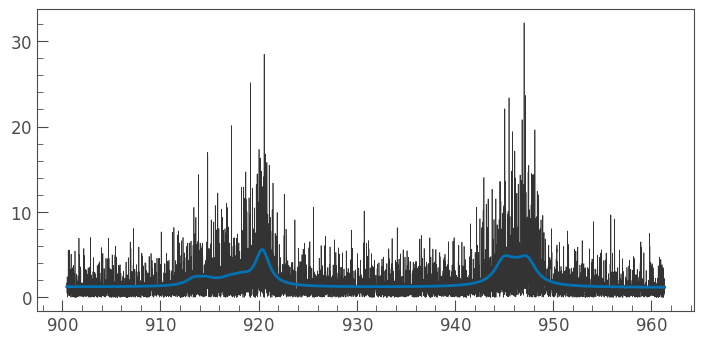

In [26]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(f, p)
    labels=['f0','f1','f2','g0','g1','g2','h0','h1','h2','split','i', 'phi']
    res = np.array([np.median(trace[label],axis=0) for label in labels])
    ax.plot(f, mod(res), lw=2)

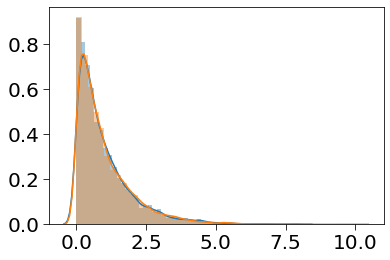

In [27]:
import seaborn as sns
sns.distplot(p/mod(res))
sns.distplot(np.random.chisquare(2, size=10000)/2)

Model looks reasonable, The model fits the $\chi_2^2$ noise, we're all good!

## Leftover content

## The smoothness conditions:

We will use the following as in Davies et al. 2016. The conditions are aimed to include the prior information that the large separation and the small separation are roughly consistent with zero at all radial orders $n$. In principle, the differences between large separations and small separations at all $n$ should be zero, although some curvature will always be present. 

For the large separation, we use:

$\ln (p(\theta_l)) = -0.125 \Large\sum^{n_{\rm max}}_{n_{\rm min}}\Large(\frac{\partial^2\nu_{n, l}}{\partial n^2})^2$



where $p(\theta_l)$ is a prior on the parameters $\theta_l$ that apply to the modes of degree $l$. This condition is applied to all sets of modes. The first derivative of the mode locations is the large separation.

We compute the double derivative as the second differences of all frequencies of equal $l$ and differing $n$ for $l = 0, 1, 2$.

For the small separation, we use:

$\ln (p(\theta_l)) = -0.25 \Large\sum^{n_{\rm max}}_{n_{\rm min}}\Large(\frac{\partial\delta\nu_{0,2}(n)}{\partial n})^2$

where we apply this prior on the $\delta\nu_{0,2}$ separations only. Technically, the radial order $n$ of the $l=2$ member of the pair will be $n-1$ compared to $l=0$, but we will treat them as both having the same $n$ as the $l=0$.

We have good constraints on the mode frequencies from previous studies, but since we are using the same data, we don't want to use their posteriors as priors on our frequencies. Instead we want to find a way to include the prior knowledge from previous studies without making our study dependent on them.

We are going to estimate the mode frequency locations using the asymptotic relation, which looks like:

$\nu_{n, l} = \Delta\nu_l (n + \frac{l}{2} + \epsilon) - \delta\nu_{0,l}$.

Because we have modes $l = \{0, 1, 2\}$, this comes with quite a few free parameters, namely:

$\Delta\nu_0$, $\Delta\nu_1$, $\Delta\nu_2$,  $\delta\nu_{01}$, $\delta\nu_{02}$, and $\epsilon$ for the initial phase offset.

While $\Delta\nu$ and $\delta\nu$ should be consistent for all modes, sound speed glitches within the star can cause curvature to occur in their values. We want to ensure their differences remain fairly consistent with zero, but with some room for uncertainty, so we'll create $N$ latent parameters $\Delta\nu_{n, l}$, where $N$ is the total number of radial overtones (and the same applies to $\delta\nu$). We'll set this up so that:

$\Delta\nu_l ~ \mathcal{N}(<\Delta\nu_l>, \sigma_l)$, and

$\delta\nu_{0,l} ~ \mathcal{N}(<\delta\nu_{0,l}>, \sigma_{0,l})$

where $<\Delta\nu_l>$ is the average large frequency separation for the $l$ modes calculated from the prior data, and $\sigma_{l}$ is a free parameter. This way we get to include the prior data on our mode locations without making our model too dependent on them. The same applies to the $\delta\nu$. Note that $\delta\nu_{0,0} = 0$, so we have one fewer set of latent parameters there.

So all in all, we have the following free and latent parameters:

$\Delta\nu_0[N] \sim \mathcal{N}(<\Delta\nu_0>, \sigma_0)$

$\Delta\nu_1[N] \sim \mathcal{N}(<\Delta\nu_1>, \sigma_1)$

$\Delta\nu_2[N] \sim \mathcal{N}(<\Delta\nu_2>, \sigma_2)$

$\delta\nu_{01}[N] \sim \mathcal{N}(<\delta\nu_{01}>, \sigma_{01}$

$\delta\nu_{02}[N] \sim \mathcal{N}(<\delta\nu_{02}>, \sigma_{02}$

$\epsilon \sim \mathcal{N}(\epsilon_{\rm prior}, ...)$

$\sigma_0 \sim \mathcal{N_{\rm half}}(...)$

$\sigma_1 \sim \mathcal{N_{\rm half}}(...)$

$\sigma_2 \sim \mathcal{N_{\rm half}}(...)$

$\sigma_01 \sim \mathcal{N_{\rm half}}(...)$

$\sigma_02 \sim \mathcal{N_{\rm half}}(...)$

